Predicted value: tensor([[0.4281]], grad_fn=<SigmoidBackward0>)


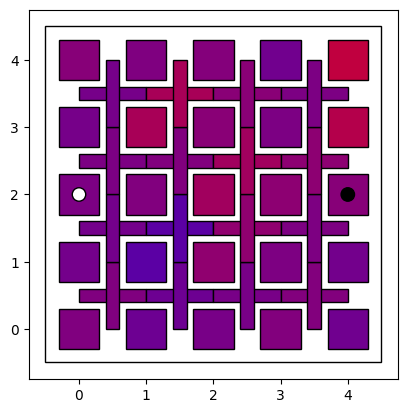

In [6]:

import numpy as np
import heapq
import itertools
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import tqdm
import matplotlib.pyplot as plt

# Module 1: GameBoardState
# Description: Manages the state of the Quoridor game board, including player positions, walls, and board representation.
# Purpose: Provides a container for the game state, allowing initialization, copying, and encoding for neural network input.
class GameBoardState:
    """
    Represents the state of a Quoridor game board.

    Attributes:
        board_size (int): Size of the board (default 9x9).
        player_locations (numpy array): 2x2 array of player positions [row, col] for players 0 and 1.
        remaining_walls (numpy array): Number of walls left for each player.
        wall_grid (numpy array): 2x(N-1)x(N-1) array for horizontal and vertical walls.
        game_board (numpy array): (2N-1)x(2N-1) array representing the board with players and walls.
    """
    def __init__(self, size=9, wall_count=10, copy_from=None):
        self.board_size = size
        if copy_from:
            self.board_size = copy_from.board_size
            self.player_locations = copy_from.player_locations.copy()
            self.remaining_walls = copy_from.remaining_walls.copy()
            self.wall_grid = copy_from.wall_grid.copy()
            self.game_board = copy_from.game_board.copy()
        else:
            self.player_locations = np.array([[0, size // 2], [size - 1, size // 2]])
            self.remaining_walls = np.array([wall_count, wall_count])
            self.wall_grid = np.zeros((2, size - 1, size - 1), dtype=np.int8)
            self.game_board = self._initialize_board()

    def _initialize_board(self):
        """
        Creates the initial game board representation.

        Returns:
            numpy array: (2N-1)x(2N-1) board with intersections marked and players positioned.
        """
        board = np.zeros((2 * self.board_size - 1, 2 * self.board_size - 1), dtype=np.int8)
        board[1::2, 1::2] = 1  # Mark intersections
        board[self.player_locations[0, 0] * 2, self.player_locations[0, 1] * 2] = 2  # Player 0
        board[self.player_locations[1, 0] * 2, self.player_locations[1, 1] * 2] = 3  # Player 1
        return board

    def duplicate(self):
        """
        Creates a deep copy of the current state.

        Returns:
            GameBoardState: A new instance with identical state.
        """
        return GameBoardState(copy_from=self)

    def encode_state(self, player):
        """
        Encodes the game state into a 4-channel tensor for neural network input.

        Args:
            player (int): Perspective player (0 or 1).

        Returns:
            numpy array: 4xNxN array with player positions and wall placements.
        """
        encoded = np.zeros((4, self.board_size, self.board_size), dtype=np.float32)
        encoded[player, self.player_locations[0, 0], self.player_locations[0, 1]] = 1
        encoded[1 - player, self.player_locations[1, 0], self.player_locations[1, 1]] = 1
        encoded[2, :, :] = np.pad(self.wall_grid[0, :, :] == 1, ((0, 1), (0, 1)), mode='constant')
        encoded[3, :, :] = np.pad(self.wall_grid[1, :, :] == 1, ((0, 1), (0, 1)), mode='constant')
        return encoded

# Module 2: QuoridorGame
# Description: Implements the rules and logic of the Quoridor game.
# Purpose: Manages game mechanics such as valid moves, wall placements, win conditions, and state transitions.
class QuoridorGame:
    """
    Manages the rules and logic for the Quoridor game.

    Attributes:
        size (int): Board size (NxN).
        wall_limit (int): Number of walls per player.
    """
    def __init__(self, size, wall_limit):
        self.size = size
        self.wall_limit = wall_limit

    def create_initial_state(self):
        """
        Initializes a new game state.

        Returns:
            GameBoardState: Starting state of the game.
        """
        return GameBoardState(self.size, self.wall_limit)

    def _find_shortest_path(self, state, player):
        """
        Uses A* algorithm to find the shortest path to the goal for a player.

        Args:
            state (GameBoardState): Current game state.
            player (int): Player index (0 or 1).

        Returns:
            int: Length of shortest path or -1 if no path exists.
        """
        board = state.game_board
        start = state.player_locations[player] * 2
        priority_queue = []
        heuristic = lambda pos: (2 * self.size - 2 - pos[0]) * (1 - player) + (2 * pos[0]) * player
        heapq.heappush(priority_queue, (-heuristic(start), 0, -1, start))
        visited = np.zeros((2 * self.size - 1, 2 * self.size - 1), dtype=np.int8)
        for step in itertools.count():
            if not priority_queue:
                return -1
            _, steps, _, pos = heapq.heappop(priority_queue)
            if pos[0] < 0 or pos[0] > 2 * self.size - 2 or pos[1] < 0 or pos[1] > 2 * self.size - 2:
                continue
            if board[*pos] == 1 or visited[*pos] == 1:
                continue
            if pos[0] == (2 * self.size - 2) * (1 - player):
                return steps
            visited[*pos] = 1
            directions = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])
            for i, direction in enumerate(directions):
                next_pos = pos + direction
                heapq.heappush(priority_queue, (-(heuristic(next_pos) + steps + 1), steps + 1, 4 * step + i, next_pos))

    def is_wall_placement_valid(self, state):
        """
        Checks if the current wall configuration allows a path to the goal for both players.

        Args:
            state (GameBoardState): Current game state.

        Returns:
            bool: True if paths exist, False otherwise.
        """
        return all(self._find_shortest_path(state, i) != -1 for i in range(2))

    def _find_possible_moves(self, state, player):
        """
        Uses DFS to find valid moves for a player, including jumps.

        Args:
            state (GameBoardState): Current game state.
            player (int): Player index (0 or 1).

        Returns:
            list: List of valid move positions.
        """
        board = state.game_board
        current_pos = state.player_locations[player] * 2
        possible_moves = []
        stack = [(current_pos, 0)]
        visited = np.zeros((2 * self.size - 1, 2 * self.size - 1), dtype=np.int8)
        while stack:
            pos, steps = stack.pop()
            if pos[0] < 0 or pos[0] > 2 * self.size - 2 or pos[1] < 0 or pos[1] > 2 * self.size - 2:
                continue
            if board[*pos] == 1 or visited[*pos] == 1:
                continue
            if board[*pos] in [2, 3]:
                steps = 0
            visited[*pos] = 1
            if steps == 2:
                possible_moves.append(pos // 2)
                continue
            for direction in np.array([[-1, 0], [1, 0], [0, -1], [0, 1]]):
                stack.append((pos + direction, steps + 1))
        return possible_moves

    def is_move_valid(self, state, target_pos, player):
        """
        Checks if a move is valid for the player.

        Args:
            state (GameBoardState): Current game state.
            target_pos (tuple): Target position (row, col).
            player (int): Player index (0 or 1).

        Returns:
            bool: True if the move is valid, False otherwise.
        """
        target = np.array(target_pos)
        return any(np.array_equal(target, move) for move in self._find_possible_moves(state, player))

    def apply_action(self, state, action, player):
        """
        Applies an action (move or wall placement) to the state.

        Args:
            state (GameBoardState): Current game state.
            action (tuple): Action type (0 for move, 1 for horizontal wall, 2 for vertical wall) and value.
            player (int): Player index (0 or 1).

        Returns:
            GameBoardState or None: New state if action is valid, None otherwise.
        """
        action_type, action_value = action
        new_state = state.duplicate()
        if action_type == 0:
            if self.is_move_valid(new_state, action_value, player):
                new_state.game_board[*new_state.player_locations[player] * 2] = 0
                new_state.game_board[*np.array(action_value) * 2] = player + 2
                new_state.player_locations[player] = action_value
                return new_state
            return None
        else:
            if new_state.remaining_walls[player] == 0:
                return None
            orientation = action_type - 1
            row, col = action_value
            if new_state.wall_grid[orientation, row, col] != 0:
                return None
            new_state.wall_grid[orientation, row, col] = 1
            new_state.wall_grid[1 - orientation, row, col] = -1
            if orientation == 0 and col > 0:
                new_state.wall_grid[0, row, col - 1] = -1
            if orientation == 1 and row > 0:
                new_state.wall_grid[1, row - 1, col] = -1
            if orientation == 0 and col < self.size - 2:
                new_state.wall_grid[0, row, col + 1] = -1
            if orientation == 1 and row < self.size - 2:
                new_state.wall_grid[1, row + 1, col] = -1
            new_state.game_board[
                row * 2 - orientation + 1: row * 2 + orientation + 2,
                col * 2 - (1 - orientation) + 1: col * 2 + (1 - orientation) + 2
            ] = 1
            new_state.remaining_walls[player] -= 1
            if not self.is_wall_placement_valid(new_state):
                return None
            return new_state

    def get_available_actions(self, state, player):
        """
        Retrieves all valid actions for a player.

        Args:
            state (GameBoardState): Current game state.
            player (int): Player index (0 or 1).

        Returns:
            list: List of valid actions (moves and wall placements).
        """
        moves = [(0, tuple(move)) for move in self._find_possible_moves(state, player)]
        walls = [
            (1 + orient, (row, col))
            for orient in range(2)
            for row in range(self.size - 1)
            for col in range(self.size - 1)
            if self.apply_action(state, (1 + orient, (row, col)), player) is not None
        ]
        return moves + walls

    def has_player_won(self, state, player):
        """
        Checks if the player has reached their goal row.

        Args:
            state (GameBoardState): Current game state.
            player (int): Player index (0 or 1).

        Returns:
            bool: True if the player has won, False otherwise.
        """
        return state.player_locations[player][0] == (self.size - 1) * (1 - player)

    def calculate_draw_score(self, state, player):
        """
        Computes a heuristic score for a draw based on shortest paths.

        Args:
            state (GameBoardState): Current game state.
            player (int): Player index (0 or 1).

        Returns:
            float: Draw score based on path lengths.
        """
        player_path = self._find_shortest_path(state, player)
        opponent_path = self._find_shortest_path(state, 1 - player)
        return player_path / (player_path + opponent_path)

    def evaluate_state(self, state, player, turns):
        """
        Determines if the game is over and assigns a value.

        Args:
            state (GameBoardState): Current game state.
            player (int): Player index (0 or 1).
            turns (int): Number of turns played.

        Returns:
            tuple: (is_terminal, is_draw, value).
        """
        if turns > 50:
            return True, True, self.calculate_draw_score(state, player)
        if self.has_player_won(state, player):
            return True, False, 1
        return False, False, 0

def parse_command(command):
    """
    Parses a command string into an action tuple.

    Args:
        command (str): Command string (e.g., "move 2 3" or "wall 0 1 2").

    Returns:
        tuple: Action type and value.

    Raises:
        ValueError: If the command is invalid.
    """
    parts = command.split()
    if parts[0] == 'move':
        return 0, (int(parts[1]), int(parts[2]))
    elif parts[0] == 'wall':
        return 1 + int(parts[1]), (int(parts[2]), int(parts[3]))
    raise ValueError('Invalid command')

# Module 3: SearchNode
# Description: Represents a node in the Monte Carlo Tree Search (MCTS) tree.
# Purpose: Stores game state, actions, and statistics for MCTS exploration and selection.
class SearchNode:
    """
    A node in the MCTS tree for Quoridor.

    Attributes:
        game (QuoridorGame): Game rule manager.
        config (dict): MCTS configuration parameters.
        state (GameBoardState): Current game state.
        player (int): Current player.
        turn_count (int): Number of turns.
        parent (SearchNode): Parent node.
        action_performed (tuple): Action leading to this node.
        children (list): Child nodes.
        available_actions (list): Valid actions not yet expanded.
        visits (int): Number of visits to this node.
        value_sum (float): Sum of values from simulations.
    """
    def __init__(self, game, config, state, player, turn_count, parent=None, action_performed=None):
        self.game = game
        self.config = config
        self.state = state
        self.player = player
        self.turn_count = turn_count
        self.parent = parent
        self.action_performed = action_performed
        self.children = []
        self.available_actions = self.game.get_available_actions(self.state, self.player)
        self.visits = 0
        self.value_sum = 0

    def is_expanded(self):
        """
        Checks if all actions have been expanded.

        Returns:
            bool: True if fully expanded, False otherwise.
        """
        return len(self.available_actions) == 0 and len(self.children) > 0

    def select_child(self):
        """
        Selects the child node with the highest UCB score.

        Returns:
            SearchNode: Best child node.
        """
        best_child, best_score = None, -np.inf
        for child in self.children:
            score = self._compute_ucb(child)
            if score > best_score:
                best_score = score
                best_child = child
        return best_child

    def _compute_ucb(self, child):
        """
        Computes the UCB score for a child node.

        Args:
            child (SearchNode): Child node.

        Returns:
            float: UCB score.
        """
        q_value = child.value_sum / (child.visits + 1e-5)
        exploration = self.config['C'] * math.sqrt(math.log(self.visits + 1) / (child.visits + 1e-5))
        return q_value + exploration

    def expand_node(self):
        """
        Expands the node by creating a child for a random unexpanded action.

        Returns:
            SearchNode: New child node.
        """
        action = random.choice(self.available_actions)
        self.available_actions.remove(action)
        child_state = self.game.apply_action(self.state, action, self.player)
        child = SearchNode(self.game, self.config, child_state, 1 - self.player, self.turn_count + 1, self, action)
        self.children.append(child)
        return child

    def run_simulation(self):
        """
        Performs a random rollout simulation from the current state.

        Returns:
            tuple: (is_draw, value).
        """
        current_state = self.state.duplicate()
        current_player = self.player
        current_turns = self.turn_count
        while True:
            is_terminal, is_draw, value = self.game.evaluate_state(current_state, current_player, current_turns)
            if is_terminal:
                return is_draw, value
            current_player = 1 - current_player
            actions = self.game.get_available_actions(current_state, current_player)
            action = random.choice(actions)
            current_state = self.game.apply_action(current_state, action, current_player)
            current_turns += 1

    def backpropagate(self, value, is_draw):
        """
        Updates node statistics and propagates values up the tree.

        Args:
            value (float): Simulation value.
            is_draw (bool): Whether the result is a draw.
        """
        self.visits += 1
        self.value_sum += value * self.config['draw_discount'] if is_draw else value
        if self.parent:
            self.parent.backpropagate(value, is_draw)

# Module 4: MCTSSearch
# Description: Implements Monte Carlo Tree Search for Quoridor.
# Purpose: Performs MCTS to select the best action by exploring the game tree.
class MCTSSearch:
    """
    Monte Carlo Tree Search implementation for Quoridor.

    Attributes:
        game (QuoridorGame): Game rule manager.
        config (dict): MCTS configuration parameters.
    """
    def __init__(self, game, config):
        self.game = game
        self.config = config

    def perform_search(self, state, player):
        """
        Runs MCTS to compute action probabilities.

        Args:
            state (GameBoardState): Current game state.
            player (int): Current player.

        Returns:
            tuple: (actions, probabilities).
        """
        root = SearchNode(self.game, self.config, state, player, 0)
        for _ in tqdm.tqdm(range(self.config['N'])):
            node = root
            while node.is_expanded():
                node = node.select_child()
            is_terminal, is_draw, value = self.game.evaluate_state(node.state, 1 - node.player, node.turn_count)
            if not is_terminal:
                node = node.expand_node()
                is_draw, value = node.run_simulation()
            node.backpropagate(value, is_draw)
        actions = [child.action_performed for child in root.children]
        probabilities = np.array([child.value_sum / (child.visits + 1e-5) for child in root.children])
        print('Node stats:', [(child.visits, child.value_sum) for child in root.children])
        probabilities /= probabilities.sum()
        return actions, probabilities

# Module 5: ResidualBlock
# Description: Defines a residual block for the neural network.
# Purpose: Provides a building block for the Quoridor neural network to learn features.
class ResidualBlock(nn.Module):
    """
    A residual block for the Quoridor neural network.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer.
        bn1 (nn.BatchNorm2d): First batch normalization layer.
        conv2 (nn.Conv2d): Second convolutional layer.
        bn2 (nn.BatchNorm2d): Second batch normalization layer.
    """
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        """
        Forward pass through the residual block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor with residual connection.
        """
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

# Module 6: QuoridorNeuralNet
# Description: Defines the neural network for Quoridor, predicting policy and value.
# Purpose: Provides a deep learning model to guide MCTS by estimating action probabilities and state values.
class QuoridorNeuralNet(nn.Module):
    """
    Neural network for Quoridor, predicting policy and value.

    Attributes:
        initial_block (nn.Sequential): Initial convolutional block.
        backbone (nn.Sequential): Stack of residual blocks.
        policy_output (nn.Sequential): Policy head for action probabilities.
        value_output (nn.Sequential): Value head for state evaluation.
    """
    def __init__(self, game, num_residuals, channels):
        super().__init__()
        self.initial_block = nn.Sequential(
            nn.Conv2d(4, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )
        self.backbone = nn.Sequential(
            OrderedDict(
                [(f'residual_{i}', ResidualBlock(channels)) for i in range(num_residuals)]
            )
        )
        self.policy_output = nn.Sequential(
            nn.Conv2d(channels, channels, 1, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, 3, 3, padding=1),
            nn.Sigmoid()
        )
        self.value_output = nn.Sequential(
            nn.Conv2d(channels, 3, 1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.size * game.size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor (4xNxN).

        Returns:
            tuple: (policy, value) tensors.
        """
        x = self.initial_block(x)
        x = self.backbone(x)
        policy = self.policy_output(x)
        value = self.value_output(x)
        return policy, value

# Example Usage and Visualization
if __name__ == "__main__":
    # Initialize game and state
    game = QuoridorGame(5, 1)
    state = game.create_initial_state()

    # Test neural network
    model = QuoridorNeuralNet(game, 3, 10)
    input_tensor = torch.tensor(state.encode_state(0)).unsqueeze(0)
    policy, value = model(input_tensor)
    print(f"Predicted value: {value}")

    # Visualize policy
    plt.figure()
    plt.gca().add_patch(plt.Rectangle((-0.5, -0.5), 5, 5, fc='w', ec='k'))
    for i in range(5):
        for j in range(5):
            rate = float(policy[0, 0, i, j])
            color = np.array([1 - rate, 0, rate, 1])
            plt.gca().add_patch(plt.Rectangle((i - 0.3, j - 0.3), 0.6, 0.6, fc=color, ec='k'))
    for i in range(4):
        for j in range(4):
            rate = float(policy[0, 0, i, j])
            color = np.array([1 - rate, 0, rate, 1])
            plt.gca().add_patch(plt.Rectangle((i + 0.5 - 0.5, j + 0.5 - 0.1), 1, 0.2, fc=color, ec='k'))
            plt.gca().add_patch(plt.Rectangle((i + 0.5 - 0.1, j + 0.5 - 0.5), 0.2, 1, fc=color, ec='k'))
    plt.gca().add_patch(plt.Circle((state.player_locations[0, 0], state.player_locations[0, 1]), 0.1, fc='w', ec='k'))
    plt.gca().add_patch(plt.Circle((state.player_locations[1, 0], state.player_locations[1, 1]), 0.1, fc='k', ec='k'))
    plt.axis('scaled')
    plt.show()

